# Step 2: normalization of raw-counts to TPM  

Made by: Cynthia Soto <br>
Date: March 17, 2021 <br>
Last md: May 26, 2022 <br>

**Assumptions:** <br>
1. A TPM normalization is applied, thus a tvs file with the gene's lenghts is required. You can process it by yourself or you can use the **Gene_length_extraction_from_GTF.ipynb** script provided to get one gene's lenghts file from a GTF file (some adjustements could be required). 
2. The **bioinfokit** package is used to normalize the data, be sure to install it before running this script.  
3. The input file to process is a tsv file with the raw-counts, the columns are the samples & the rows are the genes.

**Code goal** <br>
1. Transform raw-count into TPM values.<br>
    1. Get some stats and distributions.  <br>
    2. Plot.

**Bioinfokit package:** <br>
For install bioinfokit: https://github.com/reneshbedre/bioinfokit (Published in Bedre et al., 2019 ) <br>
bioinfokit requires: 
    Python 3
    NumPy
    scikit-learn
    seaborn
    pandas
    matplotlib
    SciPy
    matplotlib_venn
<br>
TPM latest update v0.9.1)

In [48]:
# Check the version of bioinfokit (at this time the latest version is 0.4)
import bioinfokit
bioinfokit.__version__

'2.0.8'

In [49]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bioinfokit.analys import norm, get_data    ##https://github.com/reneshbedre/bioinfokit 

# Set some initial configuration 
pd.set_option("display.precision", 3)

In [50]:
# Choose what dataset you are going to process.  
# @general_titles var is also used to label the plots and save the main and temporary files.
# general_titles="healthy"
general_titles="infected"

In [51]:
try:
    # Change the current working Directory      
    os.chdir("/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion/")
    print("Directory changed:", os.getcwd() )
except OSError:
    print("Can't change the Current Working Directory")    
#print(os.listdir(os.getcwd())       

Directory changed: /home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion


Transcript per million (TPM) normalization considers the gene length & library deep size. <br>
More details: https://www.reneshbedre.com/blog/expression_units.html <br>
If you want to better understand why normalize and filter data before any advance analysis, here a post of Jason W Hoskins about **Warnings against using unnormalized, unfiltered read counts for a few reasons** https://www.researchgate.net/post/What-is-a-valid-way-to-measure-variability-of-gene-expression-from-gtex-data 

Eg. If the TPM for gene A in sample 1 is 3.33 and the TPM in sample B is 3.33, then I know that the exact same proportion of total reads mapped to gene A in both samples. This is because the sum of the TPMs in both samples always add up to the same number.

### Declare functions

In [92]:
# Plot the distributions: values are TPM normalized
def plot_KDE2(df, samples, y_label):
    ## @df: the array(df) to be plotted (w/o column gene's names)
    ## @samples: the names to be displayed in the leyend label
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the "y" axis label.
       
    # Plot Designs for paper figure
    plt.figure(figsize=(7,4), dpi= 300)
    title_fs = 14
    xlab_fs = 12
    ylab_fs = 12
    xtick_fs = 10
    leyend_fs = 9
    titulo = 'Histogram with KDE for a normalized dataset' 
    
    sns.set_style("white")
    kwargs=dict(hist_kws={"alpha":0.6, "lw": 2})
    plt.rc('xtick',labelsize = xtick_fs)
    plt.rc('ytick',labelsize = xtick_fs)
    
    np_array = df.to_numpy()         # number of samples
    x = len(sample_lst)

    for i in range(1, x):
        sample_data = np_array[:,i]
        sns.distplot(sample_data, label = samples[i], **kwargs)   #color="dodgerblue", 
    
    plt.title(titulo, fontsize = title_fs);
    plt.xlabel(y_label,fontsize = xlab_fs);
    plt.ylabel('Probability Density',fontsize = ylab_fs);
#    plt.legend(loc='center right', fontsize = leyend_fs);    
    plt.legend("")
    #adding text inside the plot
#     plt.text(9000, 0.008, 'INPUT:\nTPM[raw-count] values', fontsize = 12,
#             bbox = dict(facecolor = 'red', alpha = 0.5))
    
    ## add arbitrary lines to canvas
    x1, y1 = [500, 29000], [0.010, 0.0005]
    plt.plot(x1, y1, 'k-', lw=1, color='blue', marker = "8")  
    #plt.savefig("../plots/all_infected_KDE_17zeros_drop.png");
    return

In [53]:
# Set ID index as "ID" to a dataframe describe() function
def df_with_label_ID(df_stat):
    df_stat.reset_index(level=0, inplace=True)
    df_stat.rename(columns={'index': 'ID'}, inplace=True)
    
    ## use this chunk if you want to give IDs to a describe() functions from a external meta-data
    #     file='../meta-data/ID_samples.csv'
    #     df_meta=pd.read_csv(file, sep='\,', engine='python', usecols=[0,4]) 
    #     #print(df_meta.head(5))
    #     ## merge by sample field
    #     df = pd.merge(df, df_meta, on="sample")    
    df_stat = df_stat.sort_values(['ID'], ascending=[True])   
    return df_stat 

In [54]:
# Plot a bar-chart as the result of the dataframe describe() function over an expression array (df)
def plot_intercuartile_bar(df, title, y_label):
    ## @df: a dataframe with the statistics generated with the describe()function 
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the y axis label.

    ## call the fuction df_with_label_ID
    df_plot = df_with_label_ID(df)
    ax = df.plot(x="ID", y="75%", kind="bar", figsize=(10,7))
    df.plot(x="ID", y="75%", kind="bar", ax=ax, color="C2")
    df.plot(x="ID", y="50%", kind="bar", ax=ax, color="C3")
    df.plot(x="ID", y="25%", kind="bar", ax=ax, color="C4")
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    plt.xticks(rotation=45,fontsize=12);
    return

# Set ID index as "ID" to trigger the describe() function over a dataframe
def df_with_label_ID(df_stat):
    try:
        # Set ID index as "ID" to a describe() function in a df
        df_stat.reset_index(level=0, inplace=True)
        df_stat.rename(columns={'index': 'ID'}, inplace=True)
        df_stat = df_stat.sort_values(['ID'], ascending=[True])   
    except:
        pass
    return df_stat 

In [55]:
# Plot a line-chart with the mean and std.dev as the result of the dataframe describe() function over an expression array (df)
def plot_mean_sdev_line(df, title, y_label):
    ## @df: a dataframe with the statistics generated with the describe()function 
    ## @title: text to be displayed as main-header in the plot
    ## @y_label: text to be displayed in the y axis label.
  
    ## gca stands for 'get current axis'
    ax = plt.gca()
    df.plot(kind='line',x='ID',y='mean',color='green', ax=ax, figsize=(10,7))
    df.plot(kind='line',x='ID',y='std', color='red', ax=ax)
    plt.title(title,fontsize=14);
    plt.xlabel('Sample ID',fontsize=14);
    plt.ylabel(y_label,fontsize=14);
    return

## Load your expression matrix

In [56]:
file_name = "matrix_A_"+ general_titles.strip() +".csv"
print(os.getcwd()+'/'+file_name)

/home/cyntsc/Proyectos/tesis-code/meta-xtrome-analysis/results-data/matrices_de_expresion/matrix_A_infected.csv


In [57]:
df_expr=pd.read_csv(file_name, header=0, sep='\t')   ## ,nrows=100  usecols=[1,3]
print(len(df_expr))

24239


In [58]:
# delete not useful columns
df_expr.drop(['zero-counter'], axis='columns', inplace=True)   #, 'Unnamed: 0'
print(df_expr.shape)
df_expr.head(5)

(24239, 18)


,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127
1,AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13
2,AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647
3,AT1G01050,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284
4,AT1G01060,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525


## Load the gene's lenghts file

In [59]:
df_gl = pd.read_csv("../../meta-data/Araport11_GFF3_genes_lenghts.csv",  usecols = ['Genes','gen_len'], header=0, sep='\t')    
df_gl.head(5)

,Genes,gen_len
0,AT1G01010,1871
1,AT1G01020,1752
2,AT1G01030,1077
3,AT1G01040,7561
4,AT1G01050,1289


         gen_len
count  27655.000
mean    1875.863
std     1502.467
min        3.000
25%      909.000
50%     1561.000
75%     2402.500
max    26941.000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa9c1f83910>]],
      dtype=object)

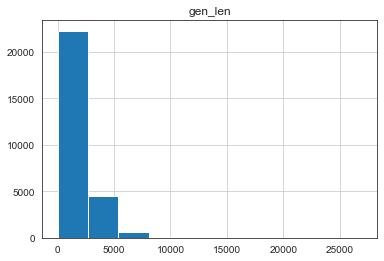

In [60]:
print(df_gl.describe())
df_gl.hist()

In [61]:
from numpy import mean, median

lst_genelng = df_gl['gen_len'].to_list()
lst_genelng.sort()
print(mean(lst_genelng))
print(median(lst_genelng))
print(max(lst_genelng))
print(min(lst_genelng))

1875.863496655216
1561.0
26941
3


## Merge the gene length df with the expr matrix df

In [62]:
## compare number of genes 
print(len(df_expr), len(df_gl))

24239 27655


With **merge** we can join data from 2 df<br>
The **how** argument to merge specifies how to determine which keys are to be included in the resulting table. If a key combination does not appear in either the left or right tables, the values in the joined table will be NA. 
Only the keys appearing in left and right are present (the intersection), since **how='inner'** by default.<br>
https://pandas.pydata.org/docs/user_guide/merging.html

In [63]:
result = pd.merge(df_expr, df_gl, on=["Genes", "Genes"])

In [64]:
len(result)

24239

In [65]:
result.head(5)

,Genes,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,gen_len
0,AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127,1752
1,AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13,1077
2,AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647,7561
3,AT1G01050,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284,1289
4,AT1G01060,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525,3070


In [66]:
result.iloc[1:10, list(range(4)) + [-1]]

,Genes,Ss30.1,Bc12,Ch40.2,gen_len
1,AT1G01030,33,6,10,1077
2,AT1G01040,57,1057,631,7561
3,AT1G01050,18,1246,258,1289
4,AT1G01060,3,798,488,3070
5,AT1G01070,4,89,96,1980
6,AT1G01080,67,1370,156,1287
7,AT1G01090,406,1367,643,1462
8,AT1G01100,94,773,605,671
9,AT1G01110,0,10,2,2256


In [67]:
# make gene column as index column
df = result.set_index('Genes')
df.head(5)

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,gen_len
Genes,,,,,,,,,,,,,,,,,,
AT1G01020,40,141,123,184,160,176,38,199,165,140,120,105,123,168,149,34,127,1752
AT1G01030,33,6,10,10,8,8,41,7,20,59,19,11,7,22,52,21,13,1077
AT1G01040,57,1057,631,1063,917,856,106,1082,1334,1176,898,613,613,1218,1149,74,647,7561
AT1G01050,18,1246,258,426,437,412,50,465,1608,857,714,247,313,871,1000,25,284,1289
AT1G01060,3,798,488,377,176,164,1,353,1058,136,10960,517,474,13574,102,2,525,3070


## Normalize the raw-counts to TPM values
**We are using the bioinfokit.analys pkg**

In [68]:
# gene length must be in bp
nm = norm()
nm.tpm(df=df, gl='gen_len')
# get TPM normalized dataframe
df_tmp = nm.tpm_norm

In [69]:
df_tmp.head(3)

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
Genes,,,,,,,,,,,,,,,,,
AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940


In [70]:
## chk the result with the total sum by column 
df_tmp.sum(axis = 0, skipna = True) 

Ss30.1    1.000e+06
Bc12      1.000e+06
Ch40.2    1.000e+06
Ch22.2    1.000e+06
Ch22.1    1.000e+06
Ch22      1.000e+06
Ss30.2    1.000e+06
Ch22.3    1.000e+06
Bc12.1    1.000e+06
Bc24.1    1.000e+06
Bc18.1    1.000e+06
Ch40.3    1.000e+06
Ch40.1    1.000e+06
Bc18      1.000e+06
Bc24      1.000e+06
Ss30      1.000e+06
Ch40      1.000e+06
dtype: float64

In [71]:
#df_tmp.to_csv("matrix_B_"+ general_titles.strip() +".csv", index=True, header=True)

In [72]:
df=df_tmp.mean()
lst_tpm = df.to_list()
lst_tpm.sort()
lst_tpm

[41.25582738561821,
 41.25582738561821,
 41.25582738561821,
 41.25582738561821,
 41.25582738561822,
 41.25582738561822,
 41.25582738561822,
 41.25582738561822,
 41.25582738561822,
 41.25582738561822,
 41.25582738561822,
 41.25582738561822,
 41.25582738561822,
 41.25582738561822,
 41.255827385618225,
 41.255827385618225,
 41.255827385618225]

## Get some stats over the normalized array

In [73]:
## Gets some stats on the new filtered array of genes with common zeros
df_plot = df_tmp.describe().T
df_plot.drop(df_plot.tail(1).index,inplace=True) # drop last n rows / or first n rows (.head)
df_plot 

,count,mean,std,min,25%,50%,75%,max
Ss30.1,24239.0,41.256,369.459,0.0,0.000,0.921,8.626,30046.794
Bc12,24239.0,41.256,258.977,0.0,0.462,7.803,25.862,21314.028
Ch40.2,24239.0,41.256,210.344,0.0,0.533,6.667,25.597,10852.459
Ch22.2,24239.0,41.256,230.030,0.0,0.693,10.173,32.238,21455.952
Ch22.1,24239.0,41.256,230.732,0.0,0.661,9.674,30.751,18793.409
Ch22,24239.0,41.256,231.031,0.0,0.667,9.622,31.043,18983.608
Ss30.2,24239.0,41.256,319.954,0.0,0.000,1.442,11.428,23508.034
Ch22.3,24239.0,41.256,229.513,0.0,0.704,10.265,32.187,21435.898
Bc12.1,24239.0,41.256,275.529,0.0,0.428,7.481,25.017,23373.501
Bc24.1,24239.0,41.256,231.174,0.0,1.143,8.871,28.965,20742.000


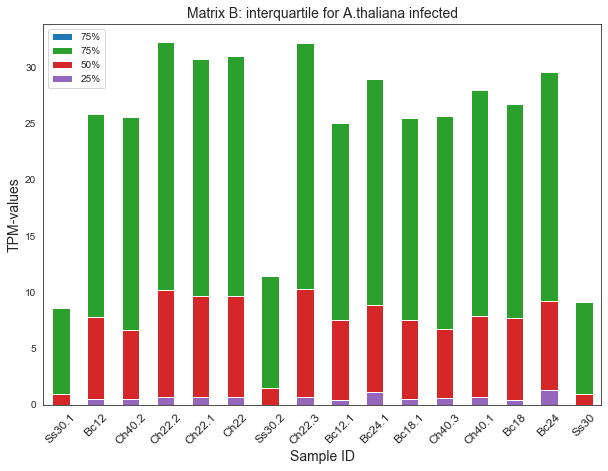

In [74]:
# Plot and save stats for the matrix type A
plot_intercuartile_bar(df_plot, 'Matrix B: interquartile for A.thaliana '+ general_titles,'TPM-values')
# df_plot.to_csv("../statistics/matrix_B_stats_"+ general_titles.strip()+".csv", index=False, header=True)

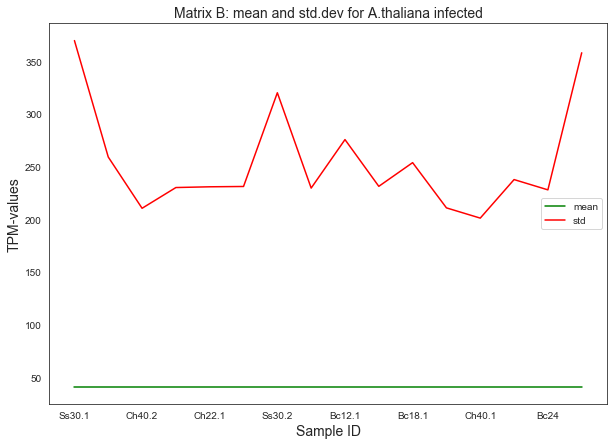

In [75]:
plot_mean_sdev_line(df_plot,'Matrix B: mean and std.dev for A.thaliana '+ general_titles,'TPM-values')

## Check the number of zeros by sample after normalization

In [76]:
sr_ceros = df_tmp.isin([0]).sum()
type(sr_ceros)
## transform the pandas serie into a pandas df
df_ceros = sr_ceros.to_frame()

In [77]:
type(sr_ceros)
sr_ceros.sort_values()

Bc24      2212
Bc24.1    2288
Ch40      3596
Ch40.1    3638
Ch40.3    3675
Ch40.2    3702
Ch22.1    3749
Ch22.2    3770
Ch22.3    3804
Ch22      3814
Bc12.1    3960
Bc12      4103
Bc18      4134
Bc18.1    4304
Ss30.2    6242
Ss30.1    7185
Ss30      7451
dtype: int64

## Check the number of zeros across all sample after normalization
Zeros will be counted by gene across all samples & a new column with the zero-counter will be appended to the matrix.

In [78]:
s_zeros =(df_tmp == 0.000).astype(int).sum(axis=1)
## Added a column to df1 with the counter of zeros
df_tmp['zero-counter'] = s_zeros
df_tmp.head(3)

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
Genes,,,,,,,,,,,,,,,,,,
AT1G01020,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503,0
AT1G01030,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248,0
AT1G01040,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940,0


**If you want to check the remaining zeros**

In [79]:
(len(df_tmp.columns)-1)

17

In [81]:
## Filter is looking for genes with 8 zeros across all samples in the healthy df (we have 8 samples for control)
##                   and genes with 17 zeros across all samples in the infected df (we have 17 samples infected)
is_zero = (df_tmp['zero-counter'] >= (len(df_tmp.columns) - 1))     
df_zero = df_tmp[is_zero]
df_zero.head(3)

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40,zero-counter
Genes,,,,,,,,,,,,,,,,,,


In [82]:
## Here, we count how many genes are not expressed in all the samples
df_zero.isin([0]).sum().head()

Ss30.1    0.0
Bc12      0.0
Ch40.2    0.0
Ch22.2    0.0
Ch22.1    0.0
dtype: float64

## Now explore the distributions with the normalized data
Plot all the sample in one plot (histogram and KDE)

In [83]:
# Method one: 
# prepar array from the current df 
#                (Both methods are equivalent)

df_tmp.reset_index(level = 0, inplace = True)
df_plot = df_tmp.drop(['Genes','zero-counter'], axis = 1)
df_plot.head(3)

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
1,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
2,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940


In [84]:
# Method two: 
# load the created one 
df_plot = pd.read_csv("matrix_B_" + general_titles.strip() + ".csv", sep = ',')  
df_plot.drop(['Genes'], axis = 1, inplace = True)
df_plot.head(3)

,Ss30.1,Bc12,Ch40.2,Ch22.2,Ch22.1,Ch22,Ss30.2,Ch22.3,Bc12.1,Bc24.1,Bc18.1,Ch40.3,Ch40.1,Bc18,Bc24,Ss30,Ch40
0,5.225,10.935,12.202,18.314,15.701,17.517,4.346,20.073,10.350,7.137,11.980,10.402,13.091,12.592,7.535,4.970,13.503
1,7.012,0.757,1.614,1.619,1.277,1.295,7.629,1.149,2.041,4.893,3.086,1.773,1.212,2.682,4.278,4.994,2.248
2,1.725,18.994,14.505,24.517,20.851,19.741,2.809,25.290,19.389,13.892,20.774,14.071,15.118,21.153,13.464,2.507,15.940


In [85]:
df_plot.shape

(24239, 17)

In [87]:
## Get sample list names
sample_lst = df_plot.columns.to_list()
print(sample_lst)

['Ss30.1', 'Bc12', 'Ch40.2', 'Ch22.2', 'Ch22.1', 'Ch22', 'Ss30.2', 'Ch22.3', 'Bc12.1', 'Bc24.1', 'Bc18.1', 'Ch40.3', 'Ch40.1', 'Bc18', 'Bc24', 'Ss30', 'Ch40']


/home/cyntsc/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensi

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/home/cyntsc/.local/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code t

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


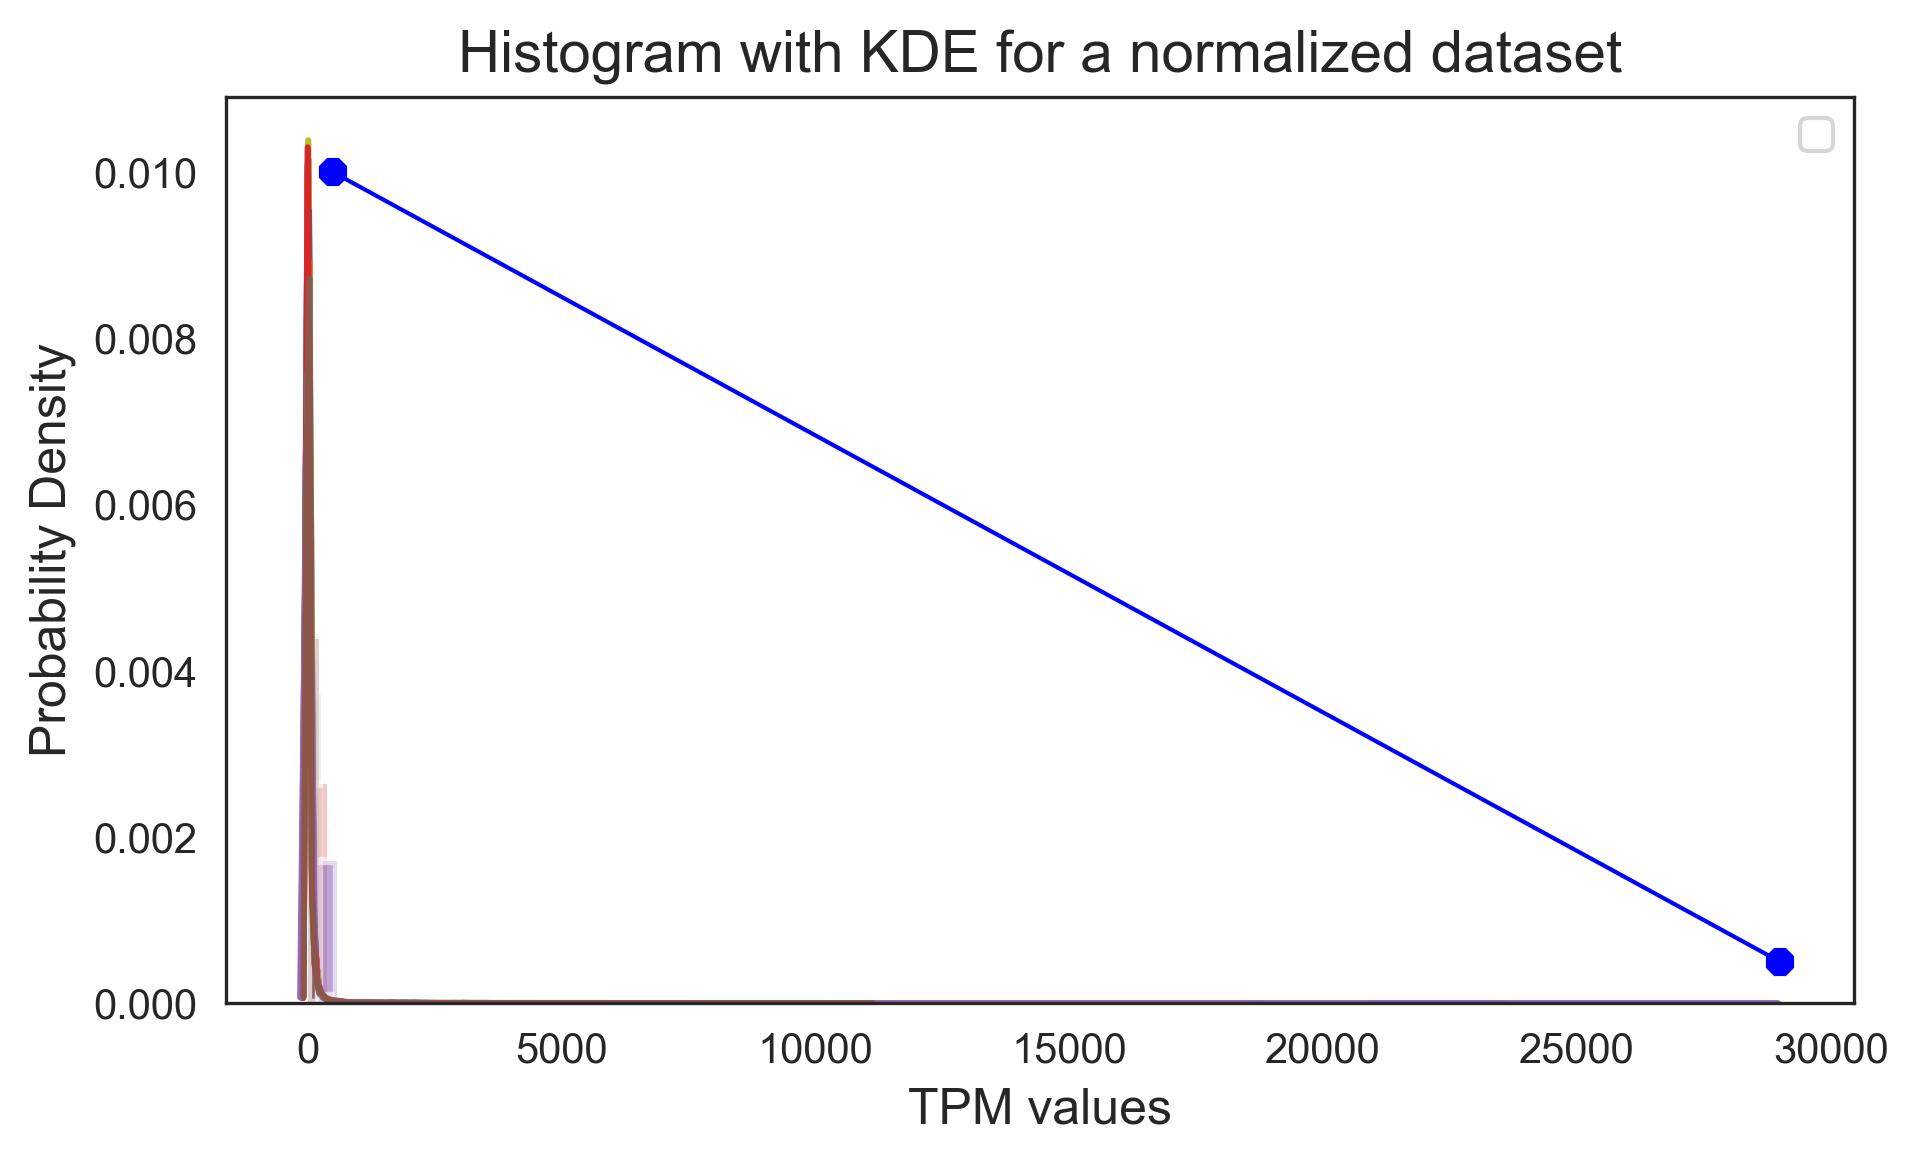

In [93]:
from importlib import reload
plt = reload(plt)

plot_KDE2(df_plot, sample_lst, 'TPM values')

In [90]:
x1, y1 = [500, 29000], [0.010, 0.0005]

In [91]:
x1

[500, 29000]